# Descrição de Atividade

Nessa atividade você irá usar seus conhecimentos sobre classificação para prever quais candidatos à Câmara de Deputados foram eleitos nas eleições de 2014. De forma específica:

 1. Há desbalanceamento das classes (isto é, uma classe tem muito mais instâncias que outra)? Em que proporção? Quais efeitos colaterais o desbalanceamento de classes pode causar no classificador? Como você poderia tratar isso? (1 pt.)
 2. Treine: um modelo de regressão logística, KNN, uma árvore de decisão e um modelo de adaboost. Tune esses modelos usando validação cruzada e controle overfitting se necessário, considerando as particularidades de cada modelo.  (2 pts.)
Reporte Precision, Recall e AUC-Precision&Recall no treino e validação. Há uma grande diferença de desempenho no treino/validação? Como você avalia os resultados? Justifique sua resposta. (2 pt.)
 3. Interprete as saídas dos modelos. Quais atributos parecem ser mais importantes de acordo com cada modelo?  (2 pts.)
 4. Envie seus melhores modelos à competição do Kaggle. Faça pelo menos uma submissão. Sugestões para melhorar o modelo: (2 pts.)
   * Experimente outros modelos (e.g. SVM, RandomForests e GradientBoosting).
   * Experimente outras estratégias de ensembles (e.g. Stacking).
   * Experimente balancear as classes,  caso estejam desbalanceadas.

Os dados estão neste link: https://www.kaggle.com/c/ufcg-cdp-20182-lab3/data. Links para um site externo

Para a entrega envie o link no GitHub com o notebook usado para resolver o Lab.


### Descrição dos dados:

Os dados utilizados correspondem aos das eleições de Deputado Federal nos anos de 2006, 2010 e 2014. Estão dividos nas seguintes colunas:

* **ano**: Ano da eleição;
* **sequencial_candidato**: O identificador do candidato. Corresponde à coluna Id do arquivo de submissão;
* **nome**: Nome do candidato;
* **uf**: Sigla do estado do candidato;
* **partido**: Partido do candidato;
* **quantidade_doacoes**: Número de doações que um candidato recebeu;
* **quantidade_doadores**: Numero de doadores que um candidato teve;
* **total_receita**: Total de receita de um candidato;
* **media_receita**: Média da receita de um candidato;
* **recursos_de_outros_candidatos.comites**: Total de receita proveniente de outros candidatos e comitês;
* **recursos_de_pessoas_fisicas**: Total de receita proveniente de pessoas físicas;
* **recursos_de_pessoas_juridicas**: Total de receita proveniente de pessoas juridicas;
* **recursos_proprios**:Total de receita proveniente dos próprios candidatos;
* **recursos_de_partido_politico**: Total de receita proveniente do partido do candidato;
* **quantidade_despesas**: Número de despesas que um candidato teve;
* **quantidade_fornecedores**: Número de fornecedores que um candidato teve;
* **total_despesa**: Total de depesa de um candidato;
* **media_despesa**: Média da despesa de um candidato;
* **cargo**: Cargo ao qual o candidato está concorrendo;
* **sexo**: Sexo do candidato;
* **grau**: Grau de escolaridade do candidato;
* **estado_civil**: Estado civil do candidato;
* **ocupacao**: Ocupação do candidato;
* **situacao**: Situação final do candidato. Corresponde à coluna **Predict** do arquivo de submissão;

## Import Libraries

In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import matplotlib.pyplot as plt

from sklearn.preprocessing import QuantileTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV
from sklearn.model_selection import cross_val_score, train_test_split, cross_validate, cross_val_predict
from sklearn.externals.joblib import Parallel, delayed
from sklearn.utils.fixes import signature

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

import xgboost as xgb
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE, ADASYN

from collections import Counter

from enum import Enum

import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls

py.init_notebook_mode(connected=True)

sns.set(style="ticks")

## Load Data

In [29]:
train_df = pd.read_csv('../data/assignment_4/train.csv')
test_df = pd.read_csv('../data/assignment_4/test.csv')

data = pd.concat([train_df, test_df], sort=False)

data.set_index('sequencial_candidato', inplace=True, drop=True)

In [30]:
train_df.iloc[1:5].T

,1,2,3,4
ano,2006,2006,2006,2006
sequencial_candidato,10002,10002,10002,10003
nome,LOIVA DE OLIVEIRA,MARIA DALVA DE SOUZA FIGUEIREDO,ROMALDO MILANI,ANSELMO DE JESUS ABREU
uf,RO,AP,MS,RO
partido,PT,PT,PRONA,PT
quantidade_doacoes,13,17,6,48
quantidade_doadores,13,16,6,48
total_receita,22826,158121,3001.12,119820
media_receita,1755.85,9301.22,500.19,2496.25
recursos_de_outros_candidatos.comites,6625,2250,0,0


## Preprocess Data

#### Feature Engineering

Abaixo criamos algumas variáveis que acreditamos ser relevantes para a análise que estamos fazendo e o modelo deve considerar entre as mais importantes para fazer predições.

In [31]:
data.drop(columns=['nome'], inplace=True)

data['sum_recursos'] = data.apply(lambda row : row['recursos_de_outros_candidatos.comites'] + 
                                               row['recursos_de_pessoas_fisicas'] +
                                               row['recursos_de_pessoas_juridicas'] +
                                               row['recursos_proprios'] +
                                               row['recursos_de_partido_politico'], axis=1)
data['lucro_campanha'] = data.apply(lambda row : row['total_receita'] - row['total_despesa'], axis=1)

#data.drop(columns=['recursos_de_outros_candidatos.comites', 'recursos_de_pessoas_fisicas',
#                   'recursos_de_pessoas_juridicas', 'recursos_proprios',
#                   'recursos_de_partido_politico'], inplace=True)

#### Skewness Correction

In [32]:
qt = QuantileTransformer(random_state=2, output_distribution='normal')

skewed_features = ['quantidade_doacoes', 'quantidade_doadores', 'total_receita',
       'media_receita','quantidade_despesas', 'quantidade_fornecedores', 'total_despesa',
       'media_despesa', 'sum_recursos', 'recursos_de_outros_candidatos.comites', 'recursos_de_pessoas_fisicas',
       'recursos_de_pessoas_juridicas', 'recursos_proprios', 'recursos_de_partido_politico']

data[skewed_features] = qt.fit_transform(X=data[skewed_features])

In [33]:
cleanup_nums = {"grau" : {"LÊ E ESCREVE": 1, 
                       "ENSINO FUNDAMENTAL INCOMPLETO":2, 
                       "ENSINO FUNDAMENTAL COMPLETO":3, 
                       "ENSINO MÉDIO INCOMPLETO":4,
                       "ENSINO MÉDIO COMPLETO":5,
                       "SUPERIOR INCOMPLETO":6,
                       "SUPERIOR COMPLETO": 7}}

data.replace(cleanup_nums, inplace=True)
data["grau"] = pd.to_numeric(data["grau"])

In [34]:
categorical_feats = [col for col in data.columns if not np.issubdtype(data[str(col)].dtype, np.number) and col not in ['nome', 'situacao']]

data = pd.get_dummies(data, columns=categorical_feats)
data.shape

(12214, 260)

## Split Data into Train and Test

In [35]:
data['situacao_dummy'] = data['situacao'].map({'eleito': 1, 'nao_eleito': 0})

train = data[(data.ano == 2006) | (data.ano == 2010)]
test = data[data.ano == 2014]

print(train.shape)
print(test.shape)

(7622, 261)
(4592, 261)


## Target Class Imbalancing

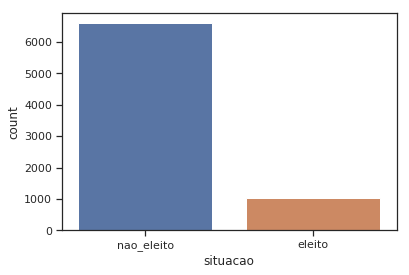

In [36]:
sns.countplot(x='situacao', data=train)

In [37]:
num_elected_candidates = train.situacao[train.situacao == 'eleito'].count()
num_not_elected_candidates = train.situacao[train.situacao == 'nao_eleito'].count()
total_candidates = train.shape[0]

print("Número de candidatos Eleitos: {}".format(num_elected_candidates))
print("Número de candidatos Não-Eleitos: {}".format(num_not_elected_candidates))
print("Total de candidatos: {}\n".format(total_candidates))

print("Proporção de candidatos eleitos: {:2.2%}".format((num_elected_candidates/total_candidates)))
print("Proporção de candidatos não-eleitos: {:2.2%}".format((num_not_elected_candidates/total_candidates)))

Número de candidatos Eleitos: 1026
Número de candidatos Não-Eleitos: 6596
Total de candidatos: 7622

Proporção de candidatos eleitos: 13.46%
Proporção de candidatos não-eleitos: 86.54%


A variável alvo **situacao** é bastante _desbalanceada_, em uma proporção de aproximadamente 1 eleito para cada 6 não-eleitos. Precisamente 13.46% dos candidatos foram eleitos, enquanto 86.54% não foram eleitos.

#### Tratando Desbalanceamento

Esse desbalanceamento pode causar alguns efeitos colaterais na classificação feita pelo modelo preditor, tais como overfitting do modelo em relação à classe majoritária, o que prejudica a acurácia da predição, podendo causar até mesmo a interpretação incorreta dos resultados se o desbalanceamento não for endereçado corretamente.

Existem algumas práticas que podemos adotar para corrigir e lidar com esse desbalanceamento, a saber:

* Coleta de mais dados, que poderia rebalancear as classes, a depender da natureza do problema;
* Mudar a forma de amostragem do dataset, a qual pode estar gerando uma amostra desbalanceada, contudo o dataset não está desbalanceado;
* Usar alguma forma de gerar dados sintéticos como Synthetic Minority Over-sampling Technique [SMOTE](https://imbalanced-learn.org/en/stable/over_sampling.html#cbhk2002) e Adaptive Synthetic [ADASYN](https://imbalanced-learn.org/en/stable/over_sampling.html#hbgl2008);
* Incorporar algum modelo que tem uma forma de penalização para compensar o desbalanceamento de classes a exemplo de penalized-LDA e penalized-SVM.


Para essa atividade nós usaremos a técnica de geração de dados sintéticos SMOTE.

In [38]:
train.drop(['situacao'], axis=1, inplace=True)
test.drop(['situacao', 'situacao_dummy'], axis=1, inplace=True)

X = train.loc[:, train.columns != 'situacao_dummy']
y = train.situacao_dummy

X_train, y_train = SMOTE().fit_resample(X, y)
print("Train SMOTE: {}".format(sorted(Counter(y_train).items())))

#X_train = pd.DataFrame(X_train, columns=X.columns)

X_test = test
print("Test.shape: {}".format(X_test.shape))

Train SMOTE: [(0.0, 6596), (1.0, 6596)]
Test.shape: (4592, 259)


# Modelos

Vamos testar duas abordagens diferentes para esse exercício: uso de **Stacking** e uso de **Boosting**.

## Stacking

#### Enumerations

In [39]:
class ModelsPaths(Enum):
    KNR_PATH = 'assignment4-models/knr.p'
    LR_PATH = 'assignment4-models/lr.p'
    DT_PATH = 'assignment4-models/dt.p'
    ADA_PATH = 'assignment4-models/ada.p'
    RF_PATH = 'assignment4-models/rf.p'
    ET_PATH = 'assignment4-models/et.p'
    SVC_PATH = 'assignment4-models/svc.p'
    LGBM_PATH = 'assignment4-models/lgbm.p'
    CAT_PATH = 'assignment4-models/cat.p'
    XGB_PATH = 'assignment4-models/xgb.p'

class ModelsNames(Enum):
    LR = 'Logistic Regression'
    DT = 'Decision Trees'
    ET = 'Extra Trees'
    RF = 'Random Forest'
    ADA = 'AdaBoost'
    SVC = 'Support Vector Machine'
    LGBM = 'LGBM'
    CAT = 'CatBoost'
    XGB = 'XGBoost'
    KNR = 'KNR'

#### Model Parameters

In [40]:
lr_params = {
    'solver': 'liblinear'
}

knr_params = {
    'n_neighbors': 3
}

dt_params = {
    
}

ada_params = {
    'learning_rate': 0.5
}

et_params = {

}

rf_params = {
    
}

svc_params = {
    'probability': True,
    'gamma' : 'auto'
}

lightgbm_params = {
    #'n_estimators':200,
    'learning_rate':0.1,
    #'num_leaves':123,
    #'colsample_bytree':0.8,
    #'subsample':0.9,
    #'max_depth':15,
    #'reg_alpha':0.1,
    #'reg_lambda':0.1,
    #'min_split_gain':0.01,
    #'min_child_weight':2  ,
    'silent': 1,
    'random_state': 42
}

catboost_params = {
    'iterations': 200,
    'learning_rate': 0.5,
    'depth': 3,
    #'l2_leaf_reg': 40,
    'bootstrap_type': 'Bernoulli',
    #'subsample': 0.7,
    #'scale_pos_weight': 5,
    'eval_metric': 'F1',
    #'od_type': 'Iter',
    'allow_writing_files': False,
    'verbose': 0
}

xgb_params = {
    #'colsample_bytree': 0.7,
    'silent': 1,
    #'subsample': 0.7,
    'learning_rate': 0.1,
    'objective': 'binary:logistic',
    #'max_depth': 2,
    #'num_parallel_tree': 1,
    #'min_child_weight': 1,
    'nrounds': 250
}

#### Grid Search CV

In [41]:
import warnings; warnings.simplefilter('ignore')

NFOLDS = 3
SEED = 42

# Construct some pipelines
pipe_rf = Pipeline([('clf', RandomForestClassifier())])
pipe_dt = Pipeline([('clf', DecisionTreeClassifier())])
pipe_ad = Pipeline([('clf', AdaBoostClassifier())])
pipe_kn = Pipeline([('clf', KNeighborsClassifier())])
pipe_et = Pipeline([('clf', ExtraTreesClassifier())])

grid_params_rf = [{'clf__max_depth' : [2,10,20,100],
                   'clf__random_state' : [SEED]}] 

grid_params_dt = [{'clf__max_depth' : [2,10,20,100],
                  'clf__random_state' : [SEED]}]

grid_params_ad = [{'clf__learning_rate' : [0.5],
                   'clf__random_state': [SEED],
                   'clf__n_estimators': [10, 20, 50]}]

grid_params_kn = [{'clf__n_neighbors': [3]}]

grid_params_et = [{'clf__max_depth' : [2,10,20,100],
                  'clf__random_state' : [SEED]}]


# Construct grid searches
jobs = -1
sc = 'f1'

gs_rf = GridSearchCV(estimator = pipe_rf,
                param_grid = grid_params_rf,
                scoring = sc,
                cv = NFOLDS) 

gs_dt = GridSearchCV(estimator = pipe_dt,
                param_grid = grid_params_dt,
                scoring = sc,
                cv = NFOLDS)

gs_ad = GridSearchCV(estimator = pipe_ad,
                param_grid = grid_params_ad,
                scoring = sc,
                cv = NFOLDS)

gs_kn = GridSearchCV(estimator = pipe_kn,
                param_grid = grid_params_kn,
                scoring = sc,
                cv = NFOLDS)

gs_et = GridSearchCV(estimator = pipe_et,
                param_grid = grid_params_et,
                scoring = sc,
                cv = NFOLDS)

# List of pipelines for ease of iteration
grids = [gs_rf, gs_dt, gs_ad, gs_kn, gs_et]

# Dictionary of pipelines and classifier types for ease of reference
grid_dict = {0: 'Random Forest Classifier', 1: 'Decision Trees', 2: 'AdaBoost Classifier', 
            3: 'KNN Classifier', 4: 'Extra Trees Classifier', 5: 'XGBoost Classifier'}


xx_train, xx_test, yy_train, yy_test = train_test_split(X_train, y_train)

# Fit the grid search objects
print('Performing model optimizations...')
for idx, gs in enumerate(grids):
    print('\nEstimator: %s' % grid_dict[idx])
    
    # Fit grid search
    gs.fit(xx_train, yy_train)

    # Best params
    print('Best params: %s' % gs.best_params_)
    
    # Best training data accuracy
    print('Best F1 score for training set: %.4f' % gs.best_score_)
    
    # Validation data accuracy of model with best params
    print('Test set F1 score for best params: %.4f ' % f1_score(y_true=yy_test, y_pred=gs.predict(xx_test)))
    
    print("----------------")

Performing model optimizations...

Estimator: Random Forest Classifier
Best params: {'clf__max_depth': 20, 'clf__random_state': 42}
Best F1 score for training set: 0.9467
Test set F1 score for best params: 0.9466 
----------------

Estimator: Decision Trees
Best params: {'clf__max_depth': 10, 'clf__random_state': 42}
Best F1 score for training set: 0.9358
Test set F1 score for best params: 0.9342 
----------------

Estimator: AdaBoost Classifier
Best params: {'clf__learning_rate': 0.5, 'clf__n_estimators': 50, 'clf__random_state': 42}
Best F1 score for training set: 0.9442
Test set F1 score for best params: 0.9419 
----------------

Estimator: KNN Classifier
Best params: {'clf__n_neighbors': 3}
Best F1 score for training set: 0.8750
Test set F1 score for best params: 0.8757 
----------------

Estimator: Extra Trees Classifier
Best params: {'clf__max_depth': 100, 'clf__random_state': 42}
Best F1 score for training set: 0.9546
Test set F1 score for best params: 0.9553 
----------------


Apesaar do bom desempenho do modelo de Extra Trees com o **max_depth** elevado, vamos deixar o valor default do parâmetro, pois provavelmente está ocorrendo overfitting com um max_depth elevado como está.

#### Model Definitions

Abaixo definimos alguns wrappers para os modelos que vamos utilizar. Créditos para [**eliotbarr**](https://www.kaggle.com/eliotbarr/stacking-test-sklearn-xgboost-catboost-lightgbm/code) e [**arthurtok**](https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python) no Kaggle.

In [42]:
ntrain = X_train.shape[0]
ntest = X_test.shape[0]

NFOLDS = 3
SEED = 42

class GenericWrapper(object):
    def __init__(self, clf, params=None, model_name=None, model_path=None):
        self.clf = clf(**params)
        self.model_name = model_name
        self.model_path = model_path

    def train(self, X_train, y_train):
        self.clf.fit(X_train, y_train)
        self._save_trained_model()

    def predict(self, x):
        return self.clf.predict(x)
    
    def predict_proba(self, x):
        return self.clf.predict_proba(x)[:,1]
    
    def get_clf(self):
        return self._load_trained_model()
    
    def _save_trained_model(self):
        pickle.dump(self.clf, open(self.model_path, 'wb'))

    def _load_trained_model(self):
        return pickle.load(open(self.model_path, 'rb'))

class SklearnWrapper_1(GenericWrapper):
    def __init__(self, clf, seed=0, params=None, model_name=None, model_path=None):
        params['random_state'] = seed
        super().__init__(clf, params, model_name, model_path)
    
    def train(self, X_train, y_train):
        super().train(X_train, y_train)
    
    def predict(self, x):
        return super().predict(x)
    
    def predict_proba(self, x):
        return super().predict_proba(x)
    
    def get_clf(self):
        return super().get_clf()
    
class SklearnWrapper_2(GenericWrapper):
    def __init__(self, clf, params=None, model_name=None, model_path=None):
        super().__init__(clf, params, model_name, model_path)
    
    def train(self, X_train, y_train):
        super().train(X_train, y_train)
    
    def predict(self, x):
        return super().predict(x)
    
    def predict_proba(self, x):
        return super().predict_proba(x)
        
    def get_clf(self):
        return super().get_clf()
    
    
class CatboostWrapper(GenericWrapper):
    def __init__(self, clf, seed=0, params=None, model_name=None, model_path=None):
        params['random_seed'] = seed
        super().__init__(clf, params, model_name, model_path)

    def train(self, X_train, y_train):
        super().train(X_train, y_train)
    
    def predict(self, x):
        return super().predict(x)
    
    def predict_proba(self, x):
        return super().predict_proba(x)
    
    def get_clf(self):
        return super().get_clf()
        

class LightGBMWrapper(GenericWrapper):
    def __init__(self, clf, seed=0, params=None, model_name=None, model_path=None):
        params['feature_fraction_seed'] = seed
        params['bagging_seed'] = seed
        super().__init__(clf, params, model_name, model_path)

    def train(self, X_train, y_train):
        super().train(X_train, y_train)
    
    def predict(self, x):
        return super().predict(x)
    
    def predict_proba(self, x):
        return super().predict_proba(x) 
    
    def get_clf(self):
        return super().get_clf()

    
class XgbWrapper(object):
    def __init__(self, seed=0, params=None, model_name=None, model_path=None):
        self.param = params
        self.param['seed'] = seed
        self.nrounds = params.pop('nrounds', 250)
        self.train_test_cols = [c for c in data.columns if c not in ['situacao', 'situacao_dummy']]
        self.model_name = model_name
        self.model_path = model_path

    def train(self, x_train, y_train):
        dtrain = xgb.DMatrix(pd.DataFrame(x_train, columns=self.train_test_cols), label=y_train)
        self.gbdt = xgb.train(self.param, dtrain, self.nrounds)
        
        self._save_trained_model()

    def predict(self, x):
        preds = self.gbdt.predict(xgb.DMatrix(pd.DataFrame(x, columns=self.train_test_cols)))   
        return [1 if x >= 0.5 else 0 for x in preds]

    def predict_proba(self, x):
        return self.gbdt.predict(xgb.DMatrix(pd.DataFrame(x, columns=self.train_test_cols)))
    
    def _save_trained_model(self):
        pickle.dump(self.gbdt, open(self.model_path, 'wb'))

    def _load_trained_model(self):
        return pickle.load(open(self.model_path, 'rb'))

#### GetOOF Function

In [43]:
def get_oof(clf):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_proba = np.zeros((ntest,))
    
    oof_test_skf = np.empty((NFOLDS, ntest))
    oof_test_skf_proba = np.empty((NFOLDS, ntest))
    
    kf = StratifiedKFold(shuffle=True, random_state=SEED, n_splits=NFOLDS)
    for i, (train_index, test_index) in enumerate(kf.split(X_train, y_train)):
        x_tr = X_train[train_index]
        y_tr = y_train[train_index]
        x_te = X_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(X_test)
        oof_test_skf_proba[i, :] = clf.predict_proba(X_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    oof_test_proba[:] = oof_test_skf_proba.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1), oof_test_proba.reshape(-1,1)

#### Training First Level Models

In [44]:
lr = SklearnWrapper_1(clf=LogisticRegression, params=lr_params, model_name=ModelsNames.LR.value, model_path=ModelsPaths.LR_PATH.value)
ad = SklearnWrapper_1(clf=AdaBoostClassifier, seed=SEED, params=ada_params, model_name=ModelsNames.ADA.value, model_path=ModelsPaths.ADA_PATH.value)
et = SklearnWrapper_1(clf=ExtraTreesClassifier, seed=SEED, params=et_params, model_name=ModelsNames.ET.value, model_path=ModelsPaths.ET_PATH.value)
rf = SklearnWrapper_1(clf=RandomForestClassifier, seed=SEED, params=rf_params, model_name=ModelsNames.RF.value, model_path=ModelsPaths.RF_PATH.value)
dt = SklearnWrapper_1(clf=DecisionTreeClassifier, seed=SEED, params=dt_params, model_name=ModelsNames.DT.value, model_path=ModelsPaths.DT_PATH.value)
sv = SklearnWrapper_1(clf=SVC, seed=SEED, params=svc_params, model_name=ModelsNames.SVC.value, model_path=ModelsPaths.SVC_PATH.value)
kn = SklearnWrapper_2(clf=KNeighborsClassifier, params=knr_params, model_name=ModelsNames.KNR.value, model_path=ModelsPaths.KNR_PATH.value)
lg = LightGBMWrapper(clf = LGBMClassifier, seed = SEED, params = lightgbm_params, model_name=ModelsNames.LGBM.value, model_path=ModelsPaths.LGBM_PATH.value)
cb = CatboostWrapper(clf= CatBoostClassifier, seed = SEED, params=catboost_params, model_name=ModelsNames.CAT.value, model_path=ModelsPaths.CAT_PATH.value)
xg = XgbWrapper(seed = SEED, params=xgb_params, model_name=ModelsNames.XGB.value, model_path=ModelsPaths.XGB_PATH.value)

tasks = [lr, ad, et, rf, dt, sv, kn, lg, cb, xg]
results = Parallel(n_jobs=-1, verbose=1)(delayed(get_oof)(md) for md in tasks)

lr_oof_train, lr_oof_test, lr_oof_test_proba = results[0]
ad_oof_train, ad_oof_test, ad_oof_test_proba = results[1]
et_oof_train, et_oof_test, et_oof_test_proba = results[2]
rf_oof_train, rf_oof_test, rf_oof_test_proba = results[3]
dt_oof_train, dt_oof_test, dt_oof_test_proba = results[4]
sv_oof_train, sv_oof_test, sv_oof_test_proba = results[5]
kn_oof_train, kn_oof_test, kn_oof_test_proba = results[6]
lg_oof_train, lg_oof_test, lg_oof_test_proba = results[7]
cb_oof_train, cb_oof_test, cb_oof_test_proba = results[8]
xg_oof_train, xg_oof_test, xg_oof_test_proba = results[9]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   12.7s remaining:    8.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  7.1min finished


### First Level Models Performance Evaluation

In [45]:
def evaluate_inter_models_results(results):
    for m_name, m_train_result in results:        
        print("Model: {}".format(m_name.value))
        print("Precision: {:.4}".format(precision_score(y_train, m_train_result)))
        print("Recall: {:.4}".format(recall_score(y_train, m_train_result)))
        print("F1: {:.4}".format(f1_score(y_train, m_train_result)))
        print("----------------------")

res = [(ModelsNames.LR, lr_oof_train), (ModelsNames.ADA, ad_oof_train), 
   (ModelsNames.ET, et_oof_train), (ModelsNames.RF, rf_oof_train), 
   (ModelsNames.DT, dt_oof_train), (ModelsNames.KNR, kn_oof_train), 
   (ModelsNames.SVC, sv_oof_train), (ModelsNames.LGBM, lg_oof_train), 
   (ModelsNames.CAT, cb_oof_train), (ModelsNames.XGB, xg_oof_train)]

evaluate_inter_models_results(res)

Model: Logistic Regression
Precision: 0.8312
Recall: 0.9207
F1: 0.8737
----------------------
Model: AdaBoost
Precision: 0.9208
Recall: 0.9709
F1: 0.9452
----------------------
Model: Extra Trees
Precision: 0.943
Recall: 0.9765
F1: 0.9595
----------------------
Model: Random Forest
Precision: 0.9395
Recall: 0.9601
F1: 0.9497
----------------------
Model: Decision Trees
Precision: 0.931
Recall: 0.9375
F1: 0.9343
----------------------
Model: KNR
Precision: 0.8433
Recall: 0.9122
F1: 0.8764
----------------------
Model: Support Vector Machine
Precision: 0.8168
Recall: 0.9438
F1: 0.8757
----------------------
Model: LGBM
Precision: 0.9495
Recall: 0.9603
F1: 0.9549
----------------------
Model: CatBoost
Precision: 0.9479
Recall: 0.9566
F1: 0.9522
----------------------
Model: XGBoost
Precision: 0.9502
Recall: 0.9639
F1: 0.957
----------------------


### Feature Importances Plots

Abaixo listamos as 10 features mais importantes elencadas por diferentes modelos que usamos, após o treinamento destes. Créditos para [**arthurtok**](https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python/notebook) no Kaggle.

##### Plotting Functions

In [46]:
def _get_top_10_features_and_imps(f_names, f_imps):
    aux = [(f_name, f_imp) for f_idx_a, f_name in f_names for f_idx_b, f_imp in f_imps if f_idx_a == f_idx_b]
    aux.sort(key=lambda tup: -tup[1]) # sort by feature_importance, descending order

    top_10_features = aux[:10]
    features_names = [x for x,_ in top_10_features]
    features_imps = [y for _,y in top_10_features]

    return (features_names, features_imps)

def _get_feat_names_and_imps_1(model):
    f_names = [(f_idx, f_name) for f_idx, f_name in enumerate(train.columns)]
    f_imps = [(f_idx, f_imp) for f_idx, f_imp in enumerate(model.feature_importances_)]

    return _get_top_10_features_and_imps(f_names, f_imps)

def _get_feat_names_and_imps_2(model):
    imps = (np.std(X_train, 0) * model.coef_)[0]

    f_names = [(f_idx, f_name) for f_idx, f_name in enumerate(train.columns)]
    f_imps = [(f_idx, f_imp) for f_idx, f_imp in enumerate(imps)]

    return _get_top_10_features_and_imps(f_names, f_imps)


def _plot_graph(model_name, features_names, features_imps):
    # Scatter plot 
    trace = go.Scatter(
        y = features_imps,
        x = features_names,
        mode='markers',
        marker=dict(
            sizemode = 'diameter',
            sizeref = 1,
            size = 25,
            color = features_imps,
            colorscale='Portland',
            showscale=True
        ),
        text = features_names
    )
    data = [trace]

    layout= go.Layout(
        autosize= True,
        title= '{} Feature Importance'.format(model_name.value),
        hovermode= 'closest',
        yaxis=dict(
            title= 'Feature Importance',
            ticklen= 5,
            gridwidth= 2
        ),
        showlegend= False
    )
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig, filename='scatter2010')


def plot_feature_importances(model, model_name):
    feature_names, feature_imps = None,None

    if model_name in [ModelsNames.DT, ModelsNames.ET, ModelsNames.RF, ModelsNames.ADA]:
        feature_names, feature_imps = _get_feat_names_and_imps_1(model)
    elif model_name in [ModelsNames.LR]:
        feature_names, feature_imps = _get_feat_names_and_imps_2(model)

    _plot_graph(model_name, feature_names, feature_imps)

#### Decision Trees, AdaBoost, Random Forest Classifier e Extra Trees Classifier

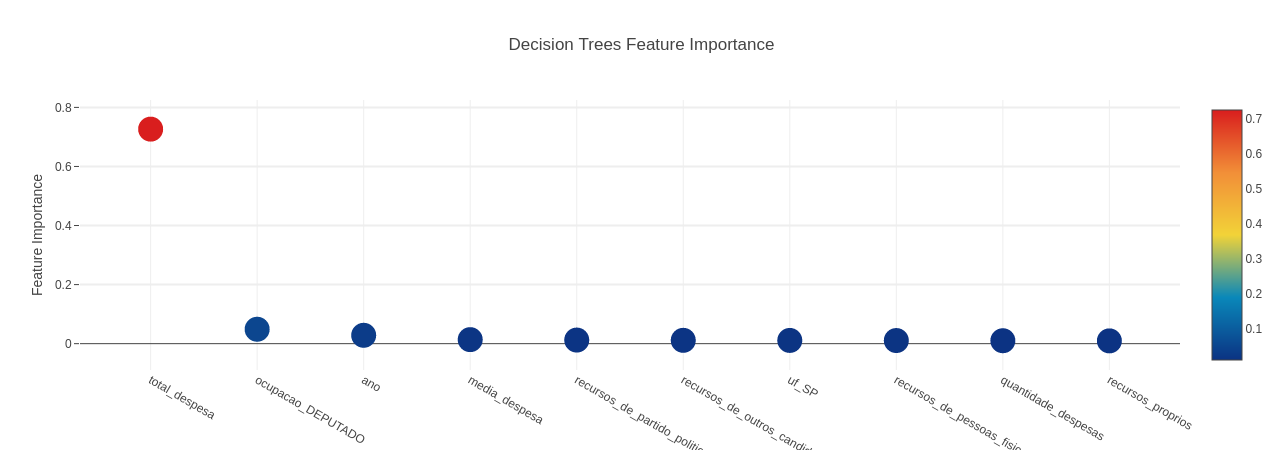

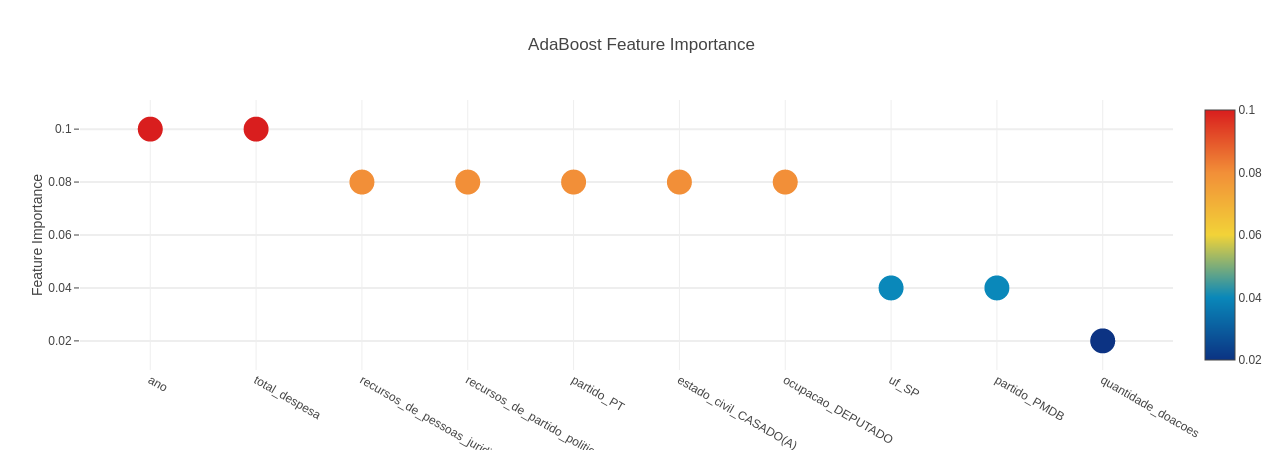

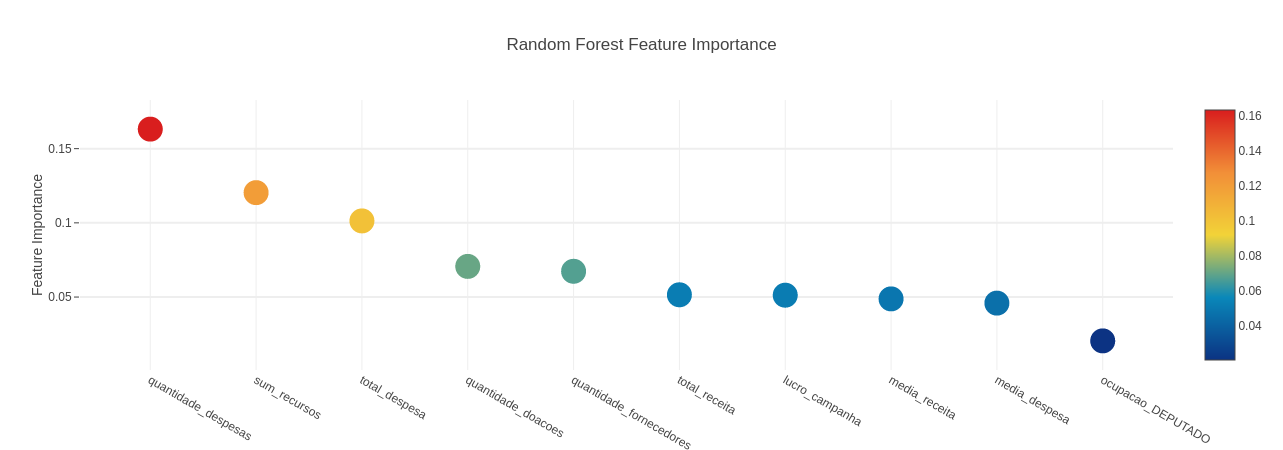

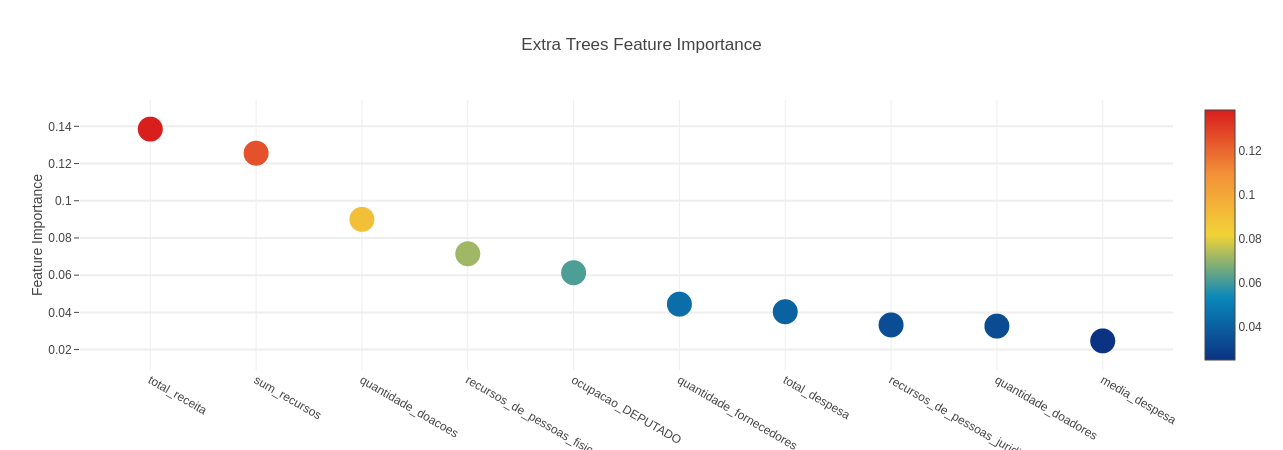

In [47]:
dt_clf = dt.get_clf() 
ad_clf = ad.get_clf() 
rf_clf = rf.get_clf() 
et_clf = et.get_clf() 

models = [(dt_clf, ModelsNames.DT), (ad_clf, ModelsNames.ADA), (rf_clf, ModelsNames.RF), (et_clf, ModelsNames.ET)]

for model, model_name in models:
    plot_feature_importances(model, model_name)

Podemos observar que esses modelos divergem quanto à principal feature que deve ser considerada para que um candidato seja eleito. Entretanto, podemos ver algumas que se repetem e que eles consideram como tendo maior importância:

* total receita
* ocupação Deputado (candidatos tentando reeleição)
* total despesa
* recursos obtidos (pessoas jurídicas, pessoas físicas, etc.)



#### Logistic Regression

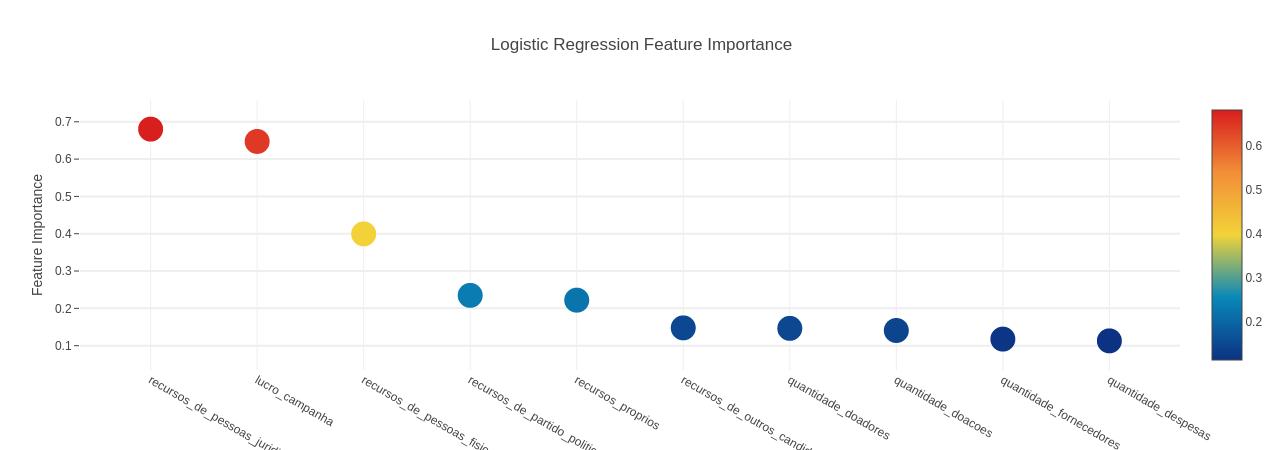

In [48]:
lr_clf = lr.get_clf()
plot_feature_importances(lr_clf, ModelsNames.LR)

O modelo de regressão logística atribui maior importância para a **quantidade de despesas** e a **quantidade de doadores** que um candidato possui como principais fatores para que ele se eleja.

## Second Level Training - Stacking

#### Stacked Model Evaluation

In [49]:
def evaluate_stacked_model(model, x__train, y__train):
    xx_train, xx_val, yy_train, yy_val = train_test_split(x__train, y__train, random_state=SEED)
    
    model.fit(xx_train, yy_train)   
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4.5), tight_layout=True)
    
    train_preds = model.predict(xx_train)
    print("\nAvaliação de Stacked Model - Train:")
    print("Precision: {:.4}".format(precision_score(yy_train, train_preds)))
    print("Recall: {:.4}".format(recall_score(yy_train, train_preds)))
    print("F1: {:.4}".format(f1_score(yy_train, train_preds)))
    __plot_pr_curve(model, xx_train, yy_train, 'Training', ax1)
    
    val_preds = model.predict(xx_val)      
    print("\nAvaliação de Stacked Model - Validation:")
    print("Precision: {:.4}".format(precision_score(yy_val, val_preds)))
    print("Recall: {:.4}".format(recall_score(yy_val, val_preds)))
    print("F1: {:.4}".format(f1_score(yy_val, val_preds)))
    __plot_pr_curve(model, xx_val, yy_val, 'Validation', ax2)

    
def __plot_pr_curve(model, x_t, y_t, name, ax):
    y_score = model.decision_function(x_t)
    average_precision = average_precision_score(y_t, y_score)
    
    precision, recall, _ = precision_recall_curve(y_t, y_score)

    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    ax.step(recall, precision, color='b', alpha=0.2, where='post')
    ax.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_ylim([0.0, 1.05])
    ax.set_xlim([0.0, 1.0])
    ax.set_title('{0} - 2-class PR-curve: AP={1:0.2f}'.format(name, average_precision))

#### Logistic Regression-based Stacking Classifier

##### _First Setup_ - **Only Selected Models**

x__train.shape: (13192, 5)
y__train.shape: (13192,)
x__test.shape:(4592, 5)

Avaliação de Stacked Model - Train:
Precision: 0.9472
Recall: 0.9727
F1: 0.9597

Avaliação de Stacked Model - Validation:
Precision: 0.9482
Recall: 0.9717
F1: 0.9598


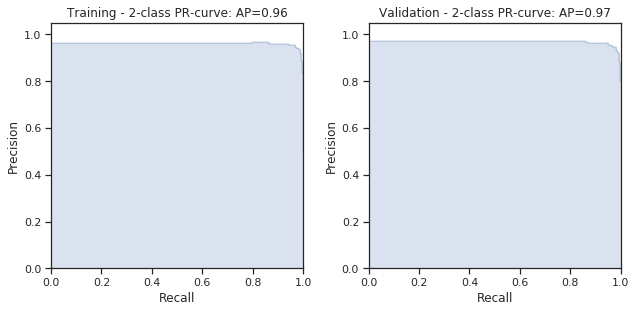

In [50]:
cols = ['ada', 'et', 'knn', 'lg', 'xg']

x__train = np.concatenate((ad_oof_train, et_oof_train, kn_oof_train, lg_oof_train, lr_oof_train), axis=1)
x__test = np.concatenate((ad_oof_test, et_oof_test, kn_oof_test, lg_oof_test, lr_oof_test), axis=1)
y__train = y_train.copy()

print("x__train.shape: {}".format(x__train.shape))
print("y__train.shape: {}".format(y__train.shape))
print("x__test.shape:{}".format(x__test.shape))

#sns.pairplot(pd.DataFrame(x__train, columns=cols))

clf = LogisticRegression(solver='liblinear')
clf.fit(x__train, y__train)

evaluate_stacked_model(clf, pd.DataFrame(x__train), pd.DataFrame(y__train))

##### _Second Setup_- **All Models**

x__train.shape: (13192, 10)
y__train.shape: (13192,)
x__test.shape:(4592, 10)

Avaliação de Stacked Model - Train:
Precision: 0.9474
Recall: 0.9735
F1: 0.9602

Avaliação de Stacked Model - Validation:
Precision: 0.95
Recall: 0.9741
F1: 0.9619


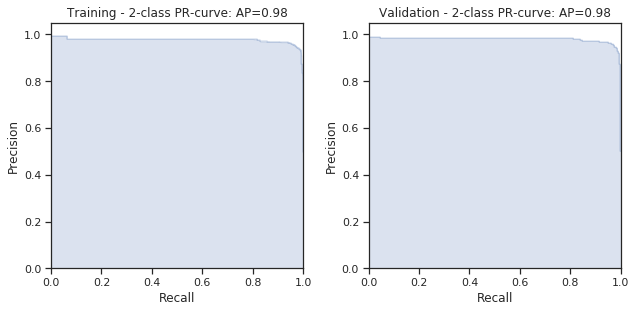

In [56]:
cols = ['ada', 'et', 'knn', 'svm', 'xg', 'cat', 'rf', 'dt', 'lg', 'lr']

x__train = np.concatenate((ad_oof_train, et_oof_train, kn_oof_train, sv_oof_train, xg_oof_train,
                           cb_oof_train, rf_oof_train, dt_oof_train, lg_oof_train, lr_oof_train), axis=1)
x__test = np.concatenate((ad_oof_test, et_oof_test, kn_oof_test, sv_oof_test, xg_oof_test, 
                          cb_oof_test, rf_oof_test, dt_oof_test, lg_oof_test, lr_oof_test), axis=1)
y__train = y_train.copy()

print("x__train.shape: {}".format(x__train.shape))
print("y__train.shape: {}".format(y__train.shape))
print("x__test.shape:{}".format(x__test.shape))

#sns.pairplot(pd.DataFrame(x__train, columns=cols))

clf = LogisticRegression(solver='liblinear')
clf.fit(x__train, y__train)

evaluate_stacked_model(clf, pd.DataFrame(x__train), pd.DataFrame(y__train))

Podemos observar que não existe muita diferença entre os valores de saída para as métricas nos datasets de validação e de treino, o que é um indício de que não há overfitting do modelo sobre os dados de treino. A precisão média (Average Precision - AP) de ambos os conjuntos de dados, treino e validação, são idênticos.

### Evaluation

Antes de inserção de xgboost em versão com wrappers:
* Avaliação de Stacked Model com CV:
* Precision: 0.9486
* Recall: 0.9616
* F1: 0.9545
* Accuracy: 0.9548
* Roc_auc: 0.98

Após inserção de xgboost em versão com wrappers:
* Avaliação de Stacked Model com CV:
* Precision: 0.9487
* Recall: 0.9616
* F1: 0.9546
* Accuracy: 0.9549
* Roc_auc: 0.9798

Após tirar alguns modelos da versão final Stacked:
* Avaliação de Stacked Model com CV:
* Precision: 0.9426
* Recall: 0.9753
* F1: 0.9585
* Accuracy: 0.958
* Roc_auc: 0.9788

Após inserir novas variáveis e fazendo com modelos selecionados
('ada', 'et', 'knn', 'lg'):
* Avaliação de Stacked Model - Validation:
* Precision: 0.9477
* Recall: 0.9723
* F1: 0.9598

Com todos os 10 modelos:
* Avaliação de Stacked Model - Validation:
* Precision: 0.9478
* Recall: 0.9741
* F1: 0.9607

Remoção de variáveis 'recursos-*'
* Avaliação de Stacked Model - Validation:
* Precision: 0.9516
* Recall: 0.9717
* F1: 0.9615

Incluindo variáveis 'recursos_*'
* Avaliação de Stacked Model - Validation:
* Precision: 0.95
* Recall: 0.9741
* F1: 0.9619

#### Generate Prediction to Test Data

In [57]:
stack_df = pd.DataFrame(X_test.copy())
pred = clf.predict(x__test)
stack_df['Predicted'] = pred

seq_candidato = stack_df.index

stack_df.replace({'Predicted': {0: 'nao_eleito', 1: 'eleito'}}, inplace=True)
stack_df.reset_index(drop=True, inplace=True)

final_df = pd.DataFrame(columns=['Id','Predicted'])
final_df['Id'] = seq_candidato
final_df['Predicted'] = stack_df['Predicted']

final_df.to_csv('../data/assignment_4/nineth_submission.csv', index=False)
final_df.head(10)

,Id,Predicted
0,10000000135,nao_eleito
1,10000000142,nao_eleito
2,10000000158,eleito
3,10000000161,nao_eleito
4,10000000163,eleito
5,10000000164,nao_eleito
6,10000000166,nao_eleito
7,10000000169,eleito
8,10000000170,nao_eleito
9,10000000171,eleito


Se compararmos as saídas dos algoritmos de boosting individualmente, nós podemos ver que relativamente ao F1-Score, eles são melhores que o algoritmo de stacking, portanto vamos fazer algumas explorações com os modelos de Extra Trees, XGBoost, CatBoost e LightBoost.

## Boosting - Boosting Models and Extra Trees Comparison

In [53]:
import warnings; warnings.simplefilter('ignore')

NFOLDS = 3
SEED = 42

# Construct some pipelines
pipe_et = Pipeline([('clf', ExtraTreesClassifier())])
pipe_cb = Pipeline([('clf', CatBoostClassifier())])
pipe_lg = Pipeline([('clf', LGBMClassifier())])
pipe_xg = Pipeline([('clf', XGBClassifier())])

grid_params_et = [{'clf__random_state' : [SEED]}]

grid_params_cb = [{'clf__random_state' : [SEED],
                   'clf__bootstrap_type': ['Bernoulli'],
                   'clf__eval_metric' : ['F1'],
                   'clf__verbose' : [0],
                   'clf__allow_writing_files': [False],
                   'clf__learning_rate': [.5],
                   'clf__iterations': [200]}] 

grid_params_lg = [{'clf__max_depth' : [2,10,20,100],
                   'clf__random_state': [SEED],
                   'clf__learning_rate': [0.1]}]

grid_params_xg = [{'clf__learning_rate' : [0.1],
                   'clf__random_state': [SEED],
                   'clf__n_estimators': [10, 20, 50],
                   'clf__silent':[1],
                   'clf__nrounds': [250],
                   'clf__objective': ['binary:logistic'],
                   'clf__nthreads': [-1]}]


# Construct grid searches
jobs = -1
sc = 'f1'

gs_et = GridSearchCV(estimator = pipe_et,
                param_grid = grid_params_et,
                scoring = sc,
                cv = NFOLDS)
                   
gs_cb = GridSearchCV(estimator = pipe_cb,
                param_grid = grid_params_cb,
                scoring = sc,
                cv = NFOLDS) 

gs_lg = GridSearchCV(estimator = pipe_lg,
                param_grid = grid_params_lg,
                scoring = sc,
                cv = NFOLDS)

gs_xg = GridSearchCV(estimator = pipe_xg,
                param_grid = grid_params_xg,
                scoring = sc,
                cv = NFOLDS)


# List of pipelines for ease of iteration
grids = [gs_et, gs_cb, gs_lg, gs_xg]

# Dictionary of pipelines and classifier types for ease of reference
grid_dict = {0: 'Extra Trees Classifier', 1: 'CatBoost Classifer', 2: 'LGBM Classifier', 3: 'XGBoost Classifier'}

xx_train, xx_test, yy_train, yy_test = train_test_split(X_train, y_train)

best_idx = 0
best_f1 = 0
best_model = None
# Fit the grid search objects
print('Performing model optimizations...')
for idx, gs in enumerate(grids):
    print('\nEstimator: %s' % grid_dict[idx])
    
    # Fit grid search
    gs.fit(xx_train, yy_train)

    # Best params
    print('Best params: %s' % gs.best_params_)
    
    # Best training data accuracy
    print('Best F1 score for training set: %.4f' % gs.best_score_)
    
    b_f1 = f1_score(y_true=yy_test, y_pred=gs.predict(xx_test))
    if b_f1 > best_f1:
        best_f1 = b_f1
        best_model = grid_dict[idx]
        best_params = gs.best_params_
    
    # Validation data accuracy of model with best params
    print('Test set F1 score for best params: %.4f ' % b_f1)
    
    print("----------------")

print('Best model is {}\nF1 score: {}\nPbarams: {}'.format(best_model, best_f1, best_params))

Performing model optimizations...

Estimator: Extra Trees Classifier
Best params: {'clf__random_state': 42}
Best F1 score for training set: 0.9546
Test set F1 score for best params: 0.9633 
----------------

Estimator: CatBoost Classifer
Best params: {'clf__allow_writing_files': False, 'clf__bootstrap_type': 'Bernoulli', 'clf__eval_metric': 'F1', 'clf__iterations': 200, 'clf__learning_rate': 0.5, 'clf__random_state': 42, 'clf__verbose': 0}
Best F1 score for training set: 0.9516
Test set F1 score for best params: 0.9543 
----------------

Estimator: LGBM Classifier
Best params: {'clf__learning_rate': 0.1, 'clf__max_depth': 100, 'clf__random_state': 42}
Best F1 score for training set: 0.9531
Test set F1 score for best params: 0.9592 
----------------

Estimator: XGBoost Classifier
Best params: {'clf__learning_rate': 0.1, 'clf__n_estimators': 50, 'clf__nrounds': 250, 'clf__nthreads': -1, 'clf__objective': 'binary:logistic', 'clf__random_state': 42, 'clf__silent': 1}
Best F1 score for trai

O model de **Ensembling Extra Trees** consegue bater os modelos de Boosting. Vamos criar um arquivo de submissão agora:

In [54]:
et_clf = ExtraTreesClassifier(random_state=SEED)
et_clf.fit(X_train, y_train)

final_df = pd.DataFrame(X_test.copy())
pred = et_clf.predict(X_test)
final_df['Predicted'] = pred

seq_candidato = final_df.index

final_df.replace({'Predicted': {0: 'nao_eleito', 1: 'eleito'}}, inplace=True)
final_df.reset_index(drop=True, inplace=True)

submit_df = pd.DataFrame(columns=['Id','Predicted'])
submit_df['Id'] = seq_candidato
submit_df['Predicted'] = final_df['Predicted']

submit_df.to_csv('../data/assignment_4/seventh_submission.csv', index=False)
submit_df.head(10)

,Id,Predicted
0,10000000135,nao_eleito
1,10000000142,nao_eleito
2,10000000158,eleito
3,10000000161,nao_eleito
4,10000000163,nao_eleito
5,10000000164,nao_eleito
6,10000000166,eleito
7,10000000169,nao_eleito
8,10000000170,nao_eleito
9,10000000171,eleito


Previouslly:

* Precision: 0.9481
* Recall: 0.9884
* F1: 0.9679
* Accuracy: 0.9678
* Roc_auc: 0.9682

After add XGBoostClassifier:

* Precision: 0.9658
* Recall: 0.9807
* F1: 0.9732
* Accuracy: 0.9735
* Roc_auc: 0.9736

### Conclusão

....